## Comparison of our Implementation with QuaPy

Evaluation will be conducted on LeQua dataset, as provided by the authors of the QuaPy package.

To be able to run this notebook, you need to install the ```quapy``` environment as provided in a yml-file in the ```envs``` folder. Further, to generate the plots, it is required to first generate the corresponding results from our ```QFY``` implementation.
This can be done from the command line, with the ```quant``` environment required to be active.
For the binary setting, one can run
```
python -m run_lequa -e 1 --modes binary -a CC AC PCC PAC EM HDy TS50 TSX TSMax MS DyS
```

To obtain the multiclass results, one can run 
```
python -m run_lequa -e 1 --modes multiclass -a CC GAC PCC GPAC EM HDy TS50 TSX TSMax MS DyS
```

In [1]:
import quapy as qp
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

from QFY.metrics import calc_eps, AE, RAE, NKLD
from helpers import melt_plotting_dataframe
from run_lequa import save_dict_to_csv
from config import *

### Step 1: Run all Methods on LeQua Data

We apply the same default base quantifiers as used in our experiments, as exported from ```config.py```, and try to mimick the parameter values as good as possible.

In [2]:
# here we initialize all QuaPy methods used in this comparison

quapy_dict = {
    "binary": { "CC": qp.method.aggregative.CC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "AC": qp.method.aggregative.ACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "PCC": qp.method.aggregative.PCC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "PAC": qp.method.aggregative.PACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "EM": qp.method.aggregative.EMQ(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "HDy": qp.method.aggregative.HDy(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "TS50": qp.method.aggregative.T50(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "TSX": qp.method.aggregative.X(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "TSMax": qp.method.aggregative.MAX(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "MS": qp.method.aggregative.MS2(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "DyS": qp.method.aggregative.DyS(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), n_bins=10, divergence="topsoe"), 
              },
    "multiclass": { "CC": qp.method.aggregative.CC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "GAC": qp.method.aggregative.ACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                    "PCC": qp.method.aggregative.PCC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "GPAC": qp.method.aggregative.PACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                    "EM": qp.method.aggregative.EMQ(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "HDy": qp.method.base.OneVsAllGeneric(qp.method.aggregative.HDy(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR))),
                    "TS50": qp.method.base.OneVsAllGeneric(qp.method.aggregative.T50(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR))),
                    "TSX": qp.method.base.OneVsAllGeneric(qp.method.aggregative.X(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "TSMax": qp.method.base.OneVsAllGeneric(qp.method.aggregative.MAX(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "MS": qp.method.base.OneVsAllGeneric(qp.method.aggregative.MS2(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "DyS": qp.method.base.OneVsAllGeneric(qp.method.aggregative.DyS(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), n_bins=10, divergence="topsoe")), 
              },
}

[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative
[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative
[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative
[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative
[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative
[warning] the quantifier seems to be an instance of qp.method.aggregative.AggregativeQuantifier; you might prefer instantiating OneVsAllAggregative


In [3]:
# function to run all desired quantifiers on LeQua data - adapted from run_main_experiments function in run_lequa.py

def run_quapy(quantifiers=None, mode="binary", seed=LEQUA_MAIN_SEED):
    
    if quantifiers is None:
        quantifiers = list(quapy_dict[mode].keys())

    for str_qf in quantifiers:

        print(f"Apply {str_qf} with default parameters on {mode} lequa data")

        curr_dict = quantify_lequa_quapy(quapy_dict[mode][str_qf], mode=mode, seed=seed)
        curr_key = f"{str_qf}-QuaPy"
        save_dict_to_csv(curr_dict, curr_key, mode)

In [4]:
# function to run singlge quantifier on LeQua data - adapted from quantify_lequa function in run_lequa.py

def quantify_lequa_quapy(qf, mode, seed):
    np.random.seed(seed)

    data_dict = LEQUA_DATA_DICT[mode]
    train_df = pd.read_csv(LEQUA_DATA_DICT[mode][LEQUA_DATA_DICT_TRAIN_DATA_PATH_KEY])
    X_train = train_df.iloc[:, 1:].to_numpy()
    y_train = train_df.label.to_numpy()
    train_data = qp.data.LabelledCollection(instances=X_train, 
                                            labels=y_train)

    Y_true = pd.read_csv(data_dict[LEQUA_DATA_DICT_TEST_PREVALENCES_PATH_KEY], index_col=0)
    test_path = data_dict[LEQUA_DATA_DICT_TEST_DATA_PATH_KEY]

    sample_size = data_dict[LEQUA_DATA_DICT_SAMPLE_SIZE_KEY]

    res_dict = dict({"qf": qf})
    res_dict["predictions"] = []
    res_dict["AE"] = []
    res_dict["RAE"] = []
    res_dict["NKLD"] = []
    
    qf.fit(train_data)

    # apply quantifiers on test data
    for i in tqdm(range(len(Y_true))):
        fname = f"{test_path}/{i}.txt"

        X_test = pd.read_csv(fname).to_numpy()

        y_true = Y_true.iloc[i].to_numpy()
        y_pred = qf.quantify(X_test)

        res_dict["predictions"].append(y_pred)
        res_dict["AE"].append(AE(y_true, y_pred))
        res_dict["RAE"].append(RAE(y_true, y_pred, eps=calc_eps(sample_size)))
        res_dict["NKLD"].append(NKLD(y_true, y_pred, eps=calc_eps(sample_size)))
        
    return res_dict

The next cell will run all quantifiers as implemented in QuaPy on the LeQua data - **this will take a while**

In [9]:
run_quapy(mode="binary")

Apply CC with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:26<00:00, 58.07it/s]


Apply AC with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:38<00:00, 50.77it/s]


Apply PCC with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:24<00:00, 58.87it/s]


Apply PAC with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:38<00:00, 50.76it/s]


Apply EM with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:26<00:00, 57.51it/s]


Apply HDy with default parameters on binary lequa data


100%|██████████| 5000/5000 [02:29<00:00, 33.35it/s]


Apply TS50 with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:25<00:00, 58.76it/s]


Apply TSX with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:20<00:00, 62.11it/s]


Apply TSMax with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:20<00:00, 62.10it/s]


Apply MS with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:27<00:00, 57.21it/s]


Apply DyS with default parameters on binary lequa data


100%|██████████| 5000/5000 [01:27<00:00, 57.12it/s]


In [10]:
run_quapy(mode="multiclass")

Apply CC with default parameters on multiclass lequa data


C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5000/5000 [03:31<00:00, 23.69it/s]


Apply GAC with default parameters on multiclass lequa data


C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Apply PCC with default parameters on multiclass lequa data


C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5000/5000 [03:27<00:00, 24.12it/s]


Apply GPAC with default parameters on multiclass lequa data


C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Apply EM with default parameters on multiclass lequa data


C:\Users\Tobias\anaconda3\envs\quapy\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5000/5000 [03:33<00:00, 23.37it/s]


Apply HDy with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [34:28<00:00,  2.42it/s]


Apply TS50 with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [03:54<00:00, 21.29it/s]


Apply TSX with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [03:55<00:00, 21.23it/s]


Apply TSMax with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [03:54<00:00, 21.32it/s]


Apply MS with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [59:31<00:00,  1.40it/s]


Apply DyS with default parameters on multiclass lequa data


100%|██████████| 5000/5000 [07:03<00:00, 11.80it/s]


### Step 2: Collect Results and Plot These

First we collect results from runs with QuaPy and our own implementation

In [5]:
def collect_quapy_result_data(mode="binary"):

    quantifiers = list(quapy_dict[mode].keys())

    qfy_res_files = [os.path.join(LEQUA_RESULT_PATH,f"{str_qf}_{mode}.csv") for str_qf in quantifiers]
    df_qfy = pd.concat([pd.read_csv(fname, index_col=0) for fname in qfy_res_files], axis=1)
    df_qfy["lib"]='QFY'

    quapy_res_files = [os.path.join(LEQUA_RESULT_PATH, f"{str_qf}-QuaPy_{mode}.csv") for str_qf in quantifiers]
    
    df_quapy = pd.read_csv(quapy_res_files[0], index_col=0)
    curr_cols = list(col.replace("-QuaPy","") for col in list(df_quapy))
    df_quapy.columns = curr_cols

    for fname in quapy_res_files[1:]:
        curr_df = pd.read_csv(fname, index_col=0)
        curr_cols = list(col.replace("-QuaPy","") for col in list(curr_df))
        curr_df.columns = curr_cols
        df_quapy = pd.concat([df_quapy, curr_df], axis=1)
        
    df_quapy["lib"]='QuaPy'


    return pd.concat([df_qfy, df_quapy], ignore_index=True)

In [6]:
df_binary = collect_quapy_result_data("binary")
df_multiclass = collect_quapy_result_data("multiclass")

res_df_dict = {"binary": df_binary,
               "multiclass": df_multiclass,
              }

Now we plot the results:

In [7]:
sns.set(**PLOTS_SNS_DEFAULT_PARAMS)

In [11]:
def boxenplot_quapy(mode="binary", 
                    measure="AE",
                    ylim=(0,2),
                    linthresh=0.01, 
                    linscale=0.25, 
                    yticks = [0,0.01,0.1,1,2], 
                    ylabels=None,
                    fname=None):

    res_df = res_df_dict[mode]
    plot_df = melt_plotting_dataframe(res_df, measure, key_cols=["lib"])
    ax = sns.boxenplot(x="alg", y="value", showfliers=False,
                       hue="lib",
                       order = plot_df.groupby("alg").median().value.sort_values().index, 
                       data=plot_df)
    
    if ylabels is None:
        ylabels = yticks

    ax.set_yscale('symlog', linthresh=linthresh, linscale = linscale)
    ax.set(ylim=ylim, ylabel = measure, xlabel=None)
    plt.xticks(rotation=90)
    plt.yticks(ticks=yticks, labels=ylabels,)
    plt.axhline(linthresh, color = "black", linestyle = '--', lw = 1)
    
    plt.grid(which='major', axis = 'y')
    plt.gcf().subplots_adjust(bottom=0.2)
    
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
                    fancybox=True, ncol=5)

    
    if fname is None:
        fname = f"quapy_comparison_{mode}_{measure}"
    plt.savefig(os.path.join(LEQUA_PLOT_PATH, fname), bbox_extra_artists=(lgd,), bbox_inches='tight') 
    plt.plot()

C:\Users\Tobias\AppData\Local\Temp\ipykernel_4452\1930943042.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = plot_df.groupby("alg").median().value.sort_values().index,
C:\Users\Tobias\AppData\Local\Temp\ipykernel_4452\1930943042.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axhline(linthresh, color = "black", linestyle = '--', lw = 1)


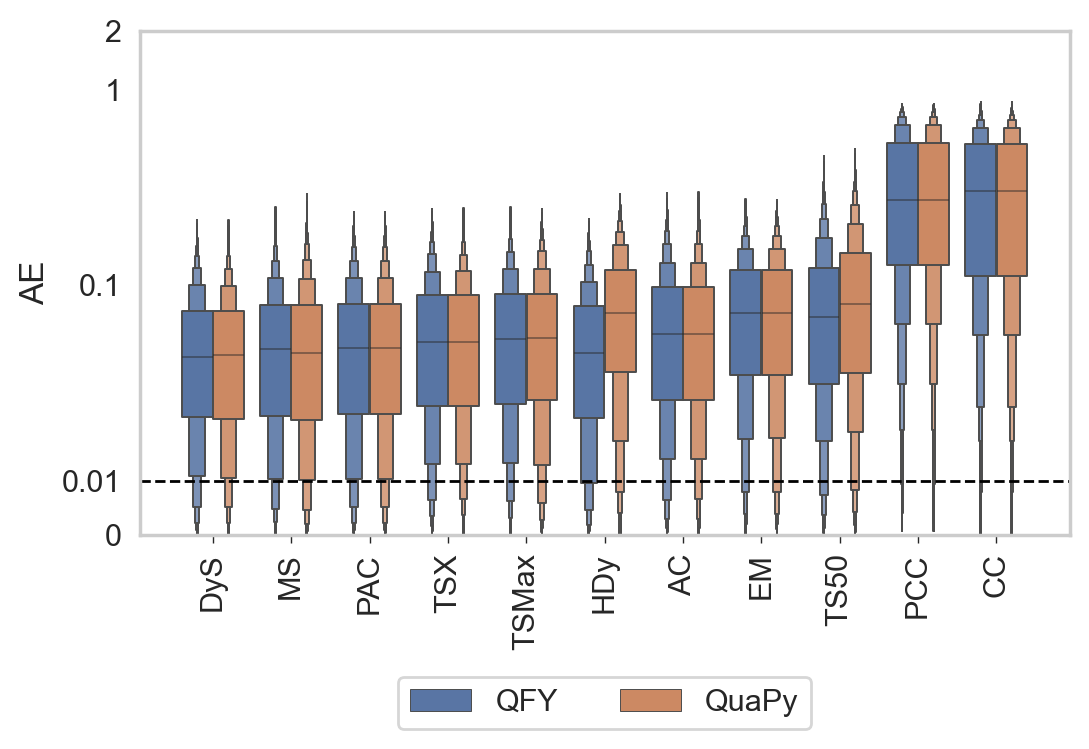

In [12]:
boxenplot_quapy("binary",
                measure="AE",
                ylim=(0,2),
                linthresh=0.01, 
                linscale=0.25, 
                yticks = [0,0.01,0.1,1,2], 
                ylabels=None,
                fname=None)

C:\Users\Tobias\AppData\Local\Temp\ipykernel_4452\1930943042.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  order = plot_df.groupby("alg").median().value.sort_values().index,
C:\Users\Tobias\AppData\Local\Temp\ipykernel_4452\1930943042.py:24: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.axhline(linthresh, color = "black", linestyle = '--', lw = 1)


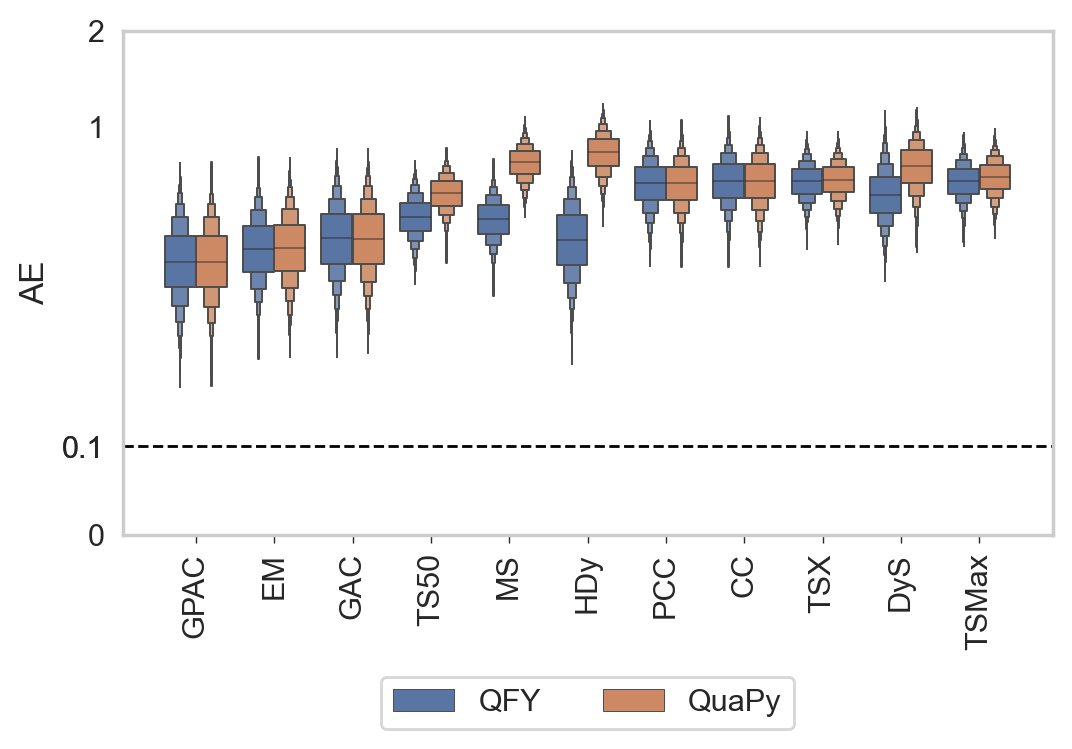

In [13]:
boxenplot_quapy("multiclass",
                measure="AE",
                ylim=(0,2),
                linthresh=0.1, 
                linscale=0.25, 
                yticks = [0,0.1,0.1,1,2], 
                ylabels=None,
                fname=None)